# Třída svítivosti

V tomto dokumentu dojde k vytvoření neuronové sítě pro rozpoznávání třídy svítivosti hvězd na základě jejich absolutní magnitudy a barevného indexu B-V. K tomu je třeba importovat následující knihovny a moduly:

In [601]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

## Příprava dat

K naučení neuronové sítě bude použit dataset dostupný přes [VizieR](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=V/137D/XHIP). Bylo vybráno pouze 579 hvězd reprezentujících všechny možné třídy svítivosti.

In [602]:
data = pd.read_csv("stars.csv")
data

,teff,mag,lum_class
0,3068,16.12,5
1,3042,16.60,5
2,2600,18.70,5
3,2800,16.65,5
4,1939,20.06,5
...,...,...,...
574,4700,1.62,3
575,4550,1.44,3
576,5000,1.65,3
577,4550,1.40,3


Z teploty `teff` nejdříve odvodíme barevný index B-V.

In [603]:
spect_classes = ["O", "B", "A", "F", "G", "K", "M", "L", "T"]
classes = ["0", "I", "II", "III", "IV", "V", "VI", "VII"]

data["bv"] = data["teff"].apply(lambda t: -3.684 * np.log10(t) + 14.551 if t < 9641 else 0.344 * np.log10(t)**2 - 3.402 * np.log10(t) + 8.037)

data

,teff,mag,lum_class,bv
0,3068,16.12,5,1.705425
1,3042,16.60,5,1.719041
2,2600,18.70,5,1.970238
3,2800,16.65,5,1.851670
4,1939,20.06,5,2.439563
...,...,...,...,...
574,4700,1.62,3,1.022991
575,4550,1.44,3,1.074886
576,5000,1.65,3,0.923995
577,4550,1.40,3,1.074886


Následně sestrojíme graf zobrazující tyto veličiny:

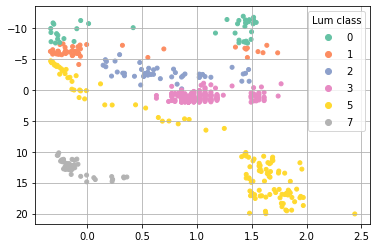

In [604]:
plt.grid()
plt.gca().invert_yaxis()
sc = plt.scatter(data["bv"], data["mag"], c=data["lum_class"], cmap="Set2", s=16)

handles, labels = sc.legend_elements(prop="colors")
legend = plt.legend(handles, labels, title="Lum class")

Jednotlivé třídy svítivosti jsou zřetelně odděleny a jejich rozmístění odpovídá [Hertzsprungovu–Russellovu diagramu](https://cs.wikipedia.org/wiki/Hertzsprung%C5%AFv%E2%80%93Russell%C5%AFv_diagram).

## Sestrojení neuronové sítě

Nejdříve definujeme architekturu sítě.

In [688]:
nn = Sequential([
    Dense(16, input_shape=(2,), activation="relu"),
    Dense(len(classes), activation="softmax")
])

nn.compile(optimizer="rmsprop", loss="mse")
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
Total params: 184
Trainable params: 184
Non-trainable params: 0
_________________________________________________________________


Následně rozdělíme námi připravená data na trénovací (80 %) a testovací (20 %).

In [689]:
data = data.sample(frac=1)  # Shuffle
data = data.reset_index(drop=True)

test_size = round(0.1 * data.shape[0])

x = data[["bv", "mag"]].to_numpy()
x_train, x_test = x[test_size:], x[:test_size]

y = np.zeros((data.shape[0], len(classes)))

for i, item in data.iterrows():
    #y[i,classes.index(item["lum_class"])] = 1
    y[i,int(item["lum_class"])] = 1
    
y_train, y_test = y[test_size:], y[:test_size]

x_train.shape, x_test.shape

((521, 2), (58, 2))

Síť naučíme z trénovacích dat:

In [690]:
stop = EarlyStopping(monitor="loss", patience=20)
nn.fit(x_train, y_train, epochs=1000, callbacks=[stop])

Epoch 1/1000
521/521 [==============================] - 0s 168us/sample - loss: 0.1584
Epoch 2/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.1380
Epoch 3/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.1191
Epoch 4/1000
521/521 [==============================] - 0s 32us/sample - loss: 0.1002
Epoch 5/1000
521/521 [==============================] - 0s 29us/sample - loss: 0.0853
Epoch 6/1000
521/521 [==============================] - 0s 26us/sample - loss: 0.0753
Epoch 7/1000
521/521 [==============================] - 0s 31us/sample - loss: 0.0675
Epoch 8/1000
521/521 [==============================] - 0s 30us/sample - loss: 0.0611
Epoch 9/1000
521/521 [==============================] - 0s 40us/sample - loss: 0.0560
Epoch 10/1000
521/521 [==============================] - 0s 31us/sample - loss: 0.0518
Epoch 11/1000
521/521 [==============================] - 0s 32us/sample - loss: 0.0482
Epoch 12/1000
521/521 [============================

521/521 [==============================] - 0s 54us/sample - loss: 0.0119
Epoch 96/1000
521/521 [==============================] - 0s 29us/sample - loss: 0.0118
Epoch 97/1000
521/521 [==============================] - 0s 31us/sample - loss: 0.0117
Epoch 98/1000
521/521 [==============================] - 0s 30us/sample - loss: 0.0116
Epoch 99/1000
521/521 [==============================] - 0s 30us/sample - loss: 0.0115
Epoch 100/1000
521/521 [==============================] - 0s 31us/sample - loss: 0.0114
Epoch 101/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0113
Epoch 102/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0112
Epoch 103/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0111
Epoch 104/1000
521/521 [==============================] - 0s 30us/sample - loss: 0.0110
Epoch 105/1000
521/521 [==============================] - 0s 30us/sample - loss: 0.0110
Epoch 106/1000
521/521 [===========================

521/521 [==============================] - 0s 28us/sample - loss: 0.0066
Epoch 189/1000
521/521 [==============================] - 0s 32us/sample - loss: 0.0065
Epoch 190/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0065
Epoch 191/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.0064
Epoch 192/1000
521/521 [==============================] - 0s 26us/sample - loss: 0.0065
Epoch 193/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.0064
Epoch 194/1000
521/521 [==============================] - 0s 30us/sample - loss: 0.0064
Epoch 195/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0064
Epoch 196/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0063
Epoch 197/1000
521/521 [==============================] - 0s 31us/sample - loss: 0.0063
Epoch 198/1000
521/521 [==============================] - 0s 32us/sample - loss: 0.0063
Epoch 199/1000
521/521 [=======================

521/521 [==============================] - 0s 26us/sample - loss: 0.0048
Epoch 282/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0048
Epoch 283/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.0048
Epoch 284/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0047
Epoch 285/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0047
Epoch 286/1000
521/521 [==============================] - 0s 26us/sample - loss: 0.0047
Epoch 287/1000
521/521 [==============================] - 0s 32us/sample - loss: 0.0047
Epoch 288/1000
521/521 [==============================] - 0s 26us/sample - loss: 0.0047
Epoch 289/1000
521/521 [==============================] - 0s 30us/sample - loss: 0.0048
Epoch 290/1000
521/521 [==============================] - 0s 32us/sample - loss: 0.0047
Epoch 291/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0047
Epoch 292/1000
521/521 [=======================

521/521 [==============================] - 0s 24us/sample - loss: 0.0040
Epoch 375/1000
521/521 [==============================] - 0s 38us/sample - loss: 0.0040
Epoch 376/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0040
Epoch 377/1000
521/521 [==============================] - 0s 26us/sample - loss: 0.0040
Epoch 378/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0040
Epoch 379/1000
521/521 [==============================] - 0s 29us/sample - loss: 0.0040
Epoch 380/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.0040
Epoch 381/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0040
Epoch 382/1000
521/521 [==============================] - 0s 23us/sample - loss: 0.0040
Epoch 383/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0040
Epoch 384/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0040
Epoch 385/1000
521/521 [=======================

521/521 [==============================] - 0s 30us/sample - loss: 0.0036
Epoch 468/1000
521/521 [==============================] - 0s 23us/sample - loss: 0.0036
Epoch 469/1000
521/521 [==============================] - 0s 26us/sample - loss: 0.0036
Epoch 470/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0036
Epoch 471/1000
521/521 [==============================] - 0s 26us/sample - loss: 0.0036
Epoch 472/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0036
Epoch 473/1000
521/521 [==============================] - 0s 29us/sample - loss: 0.0036
Epoch 474/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0036
Epoch 475/1000
521/521 [==============================] - 0s 30us/sample - loss: 0.0035
Epoch 476/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0036
Epoch 477/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0035
Epoch 478/1000
521/521 [=======================

Epoch 560/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0033
Epoch 561/1000
521/521 [==============================] - 0s 29us/sample - loss: 0.0033
Epoch 562/1000
521/521 [==============================] - 0s 23us/sample - loss: 0.0033
Epoch 563/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0033
Epoch 564/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0033
Epoch 565/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0033
Epoch 566/1000
521/521 [==============================] - 0s 32us/sample - loss: 0.0033
Epoch 567/1000
521/521 [==============================] - 0s 23us/sample - loss: 0.0033
Epoch 568/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.0033
Epoch 569/1000
521/521 [==============================] - 0s 26us/sample - loss: 0.0032
Epoch 570/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0033
Epoch 571/1000
521/521 [========

521/521 [==============================] - 0s 28us/sample - loss: 0.0031
Epoch 654/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0031
Epoch 655/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0032
Epoch 656/1000
521/521 [==============================] - 0s 27us/sample - loss: 0.0031
Epoch 657/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0031
Epoch 658/1000
521/521 [==============================] - 0s 26us/sample - loss: 0.0031
Epoch 659/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.0031
Epoch 660/1000
521/521 [==============================] - 0s 23us/sample - loss: 0.0031
Epoch 661/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0031
Epoch 662/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.0031
Epoch 663/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0031
Epoch 664/1000
521/521 [=======================

521/521 [==============================] - 0s 29us/sample - loss: 0.0029
Epoch 747/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.0029
Epoch 748/1000
521/521 [==============================] - 0s 25us/sample - loss: 0.0030
Epoch 749/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0029
Epoch 750/1000
521/521 [==============================] - 0s 30us/sample - loss: 0.0029
Epoch 751/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0030
Epoch 752/1000
521/521 [==============================] - 0s 31us/sample - loss: 0.0030
Epoch 753/1000
521/521 [==============================] - 0s 29us/sample - loss: 0.0029
Epoch 754/1000
521/521 [==============================] - 0s 23us/sample - loss: 0.0029
Epoch 755/1000
521/521 [==============================] - 0s 24us/sample - loss: 0.0030
Epoch 756/1000
521/521 [==============================] - 0s 28us/sample - loss: 0.0029
Epoch 757/1000
521/521 [=======================

Nakonec otestujeme úspěšnost sítě.

In [691]:
result = nn.predict(x_test)
(result.argmax(axis=1) == y_test.argmax(axis=1)).sum() / len(result)

0.9827586206896551

Úspěšnost sítě se pohybuje mezi 95 % a 100 %, což je pro účely aplikace dostačující. Pro použití i mimo tento dokument vytvořenou a naučenou neuronovou síť uložíme do souboru.

In [692]:
nn.save("lum_class.h5")

x = load_model("lum_class.h5")
x.predict(np.array([[0.716, 5.32]])).argmax()

5

In [671]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np


tf.keras.backend.clear_session()

lum_class_nn = load_model("lum_class.h5")
global graph
global sess
graph = tf.get_default_graph()
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)


class NN:

    @staticmethod
    def predict_class(instance, input):
        x = NN.predict(instance, input).argmax()
        return x

    @staticmethod
    def predict(instance, input):
        with graph.as_default():
            tf.keras.backend.set_session(sess)
            return instance.predict(np.array([input]))[0]
        
NN.predict_class(lum_class_nn, [0.716, 5.32]), lum_class_nn.predict(np.array([[0.716, 5.32]])).argmax()

(4, 4)